In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import random
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from PIL import Image
from tqdm import tqdm
from IPython.display import clear_output

In [78]:
dataset, info = tfds.load('scene_parse150', with_info=True)

In [81]:
num_classes = info.features['annotation']

print(num_classes)

Image(shape=(None, None, 3), dtype=uint8)


Сначала мы нормализуем значения пикселей в диапазоне [0,1]. Для этого мы разделим значение каждого пикселя на 255. Пиксели сегментационной маски будут помечены {1, 2, 3}, но для удобства из данного цифрового ряда будет вычтено по 1 и в итоге получиться {0, 1, 2}. Набор данных, включенный из TensorFlow, уже разделен на обучающий и тестовый сплит.

Функция для создания обучающего датасета аугументируют данные используя поворот

In [ ]:
def normalize(input_image, input_mask):

	# Normalize the pixel range values between [0:1]
	img = tf.cast(input_image, dtype=tf.float32) / 255.0 # tf.cast приводит тензор к новому типу.
	input_mask -= 1
	return img, input_mask

@tf.function
def load_train_ds(dataset):
	img = tf.image.resize(dataset['image'],
						size=(width, height))
	mask = tf.image.resize(dataset['annotation'],
						size=(width, height))

	if tf.random.uniform(()) > 0.5:
		img = tf.image.flip_left_right(img)
		mask = tf.image.flip_left_right(mask)

	img, mask = normalize(img, mask)
	return img, mask

@tf.function
def load_test_ds(dataset):
	img = tf.image.resize(dataset['image'],
						size=(width, height))
	mask = tf.image.resize(dataset['annotation'],
						size=(width, height))

	img, mask = normalize(img, mask)
	return img, mask

Теперь мы установим некоторые постоянные значения, такие как размер буфера, высота и ширина ввода и т.д.

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples

# Batch size is the number of examples used in one training example.
# It is mostly a power of 2
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# For VGG16 this is the input size
width, height = 256, 256

In [ ]:
train = dataset['train'].map(
	load_train_ds, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_test_ds)

train_ds = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.batch(BATCH_SIZE)

In [ ]:
for img in dataset['train']:
  print(img.keys())
  break

dict_keys(['annotation', 'image'])


In [ ]:
train.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None))>

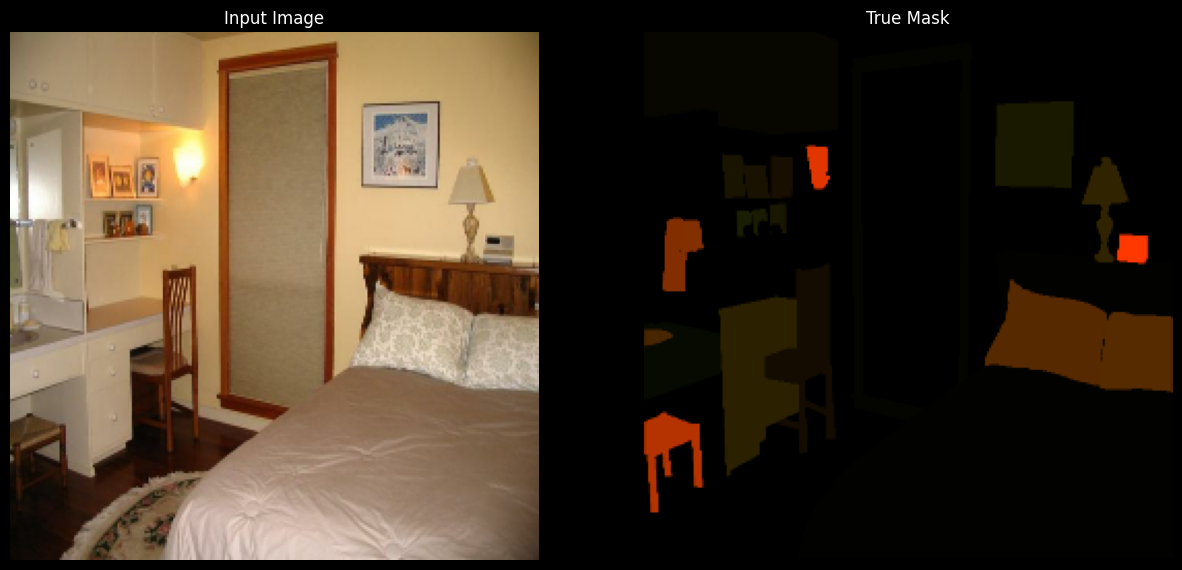

In [ ]:
def display_images(display_list):
	plt.figure(figsize=(15, 15))
	title = ['Input Image', 'True Mask',
			'Predicted Mask']

	for i in range(len(display_list)):
		plt.subplot(1, len(display_list), i+1)
		plt.title(title[i])
		plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
		plt.axis('off')

	plt.show()


for img, mask in train.take(1):
	sample_image, sample_mask = img, mask
	display_list = sample_image, sample_mask

display_images(display_list)


## U-Net
U-Net - это архитектура CNN, используемая для большинства задач сегментации. Она состоит из пути сжатия и расширения, что дает ей название UNet. Путь сжатия состоит из слоя свертки, за которым следует ReLU, за которым следуют слои с максимальным объединением. По пути сжатия объекты извлекаются и пространственная информация уменьшается. По пути расширения выполняется серия сверток вверх вместе с объединением объектов с близким разрешением по пути сжатия.

In [ ]:
base_model = keras.applications.vgg16.VGG16(
    include_top=False, input_shape=(width, height, 3))

layer_names = [
    'block1_pool',
    'block2_pool',
    'block3_pool',
    'block4_pool',
    'block5_pool',
]
base_model_outputs = [base_model.get_layer(
    name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input,
                               base_model_outputs)

Теперь определите декодер

In [ ]:
def fcn8_decoder(convs, n_classes):
	f1, f2, f3, f4, p5 = convs

	n = 4096
	c6 = tf.keras.layers.Conv2D(
		n, (7, 7), activation='relu', padding='same',
	name="conv6")(p5)
	c7 = tf.keras.layers.Conv2D(
		n, (1, 1), activation='relu', padding='same',
	name="conv7")(c6)

	f5 = c7

	# upsample the output of the encoder
	# then crop extra pixels that were introduced
	o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(
		4, 4), strides=(2, 2), use_bias=False)(f5)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 4 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f4
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu',
								padding='same'))(o2)

	# add the results of the upsampling and pool 4 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample the resulting tensor of the operation you just did
	o = (tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(4, 4), strides=(2, 2),
	use_bias=False))(o)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 3 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f3
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu',
								padding='same'))(o2)

	# add the results of the upsampling and pool 3 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample up to the size of the original image
	o = tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(8, 8), strides=(8, 8),
	use_bias=False)(o)

	# append a softmax to get the class probabilities
	o = tf.keras.layers.Activation('softmax')(o)
	return o


Объединение всего, создание окончательной модели и ее компиляция

In [ ]:
def segmentation_model():

	inputs = keras.layers.Input(shape=(width, height, 3))
	convs = VGG_16(inputs)
	outputs = fcn8_decoder(convs, n_classes = 3)
	model = tf.keras.Model(inputs=inputs, outputs=outputs)

	return model


opt = keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer=opt,
			loss=tf.keras.losses.CategoricalCrossentropy(
				from_logits=False),
			metrics=['accuracy'])

Утилита создания маски прогнозирования

1/1 [==============================] - 1s 950ms/step


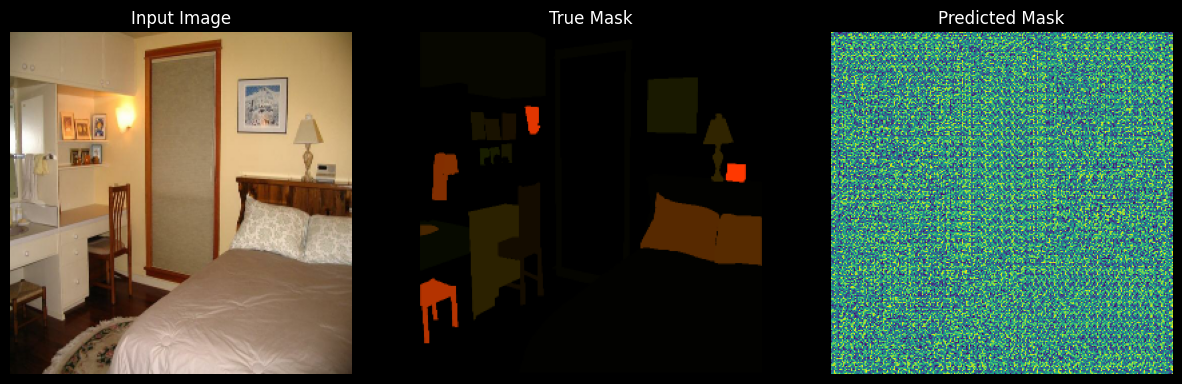

In [ ]:
def create_mask(pred_mask):
	pred_mask = tf.argmax(pred_mask, axis=-1)
	pred_mask = pred_mask[..., tf.newaxis]
	return pred_mask[0]


def show_predictions(dataset=None, num=1):
	if dataset:
		for image, mask in dataset.take(num):
			pred_mask = model.predict(image)
			display_images([image[0], mask[0], create_mask(pred_mask)])
	else:
		display_images([sample_image, sample_mask,
						create_mask(model.predict(sample_image[tf.newaxis, ...]))])


show_predictions()

# Обучение

In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_ds, epochs=EPOCHS,
						steps_per_epoch=STEPS_PER_EPOCH,
						validation_steps=VALIDATION_STEPS,
						validation_data=test_ds)

Epoch 1/2


ValueError: in user code:

    File "c:\ProgramData\anaconda3\envs\py311\envs\TensorFlow-GPU\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\ProgramData\anaconda3\envs\py311\envs\TensorFlow-GPU\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\anaconda3\envs\py311\envs\TensorFlow-GPU\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\ProgramData\anaconda3\envs\py311\envs\TensorFlow-GPU\Lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\ProgramData\anaconda3\envs\py311\envs\TensorFlow-GPU\Lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "c:\ProgramData\anaconda3\envs\py311\envs\TensorFlow-GPU\Lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\ProgramData\anaconda3\envs\py311\envs\TensorFlow-GPU\Lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\ProgramData\anaconda3\envs\py311\envs\TensorFlow-GPU\Lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\ProgramData\anaconda3\envs\py311\envs\TensorFlow-GPU\Lib\site-packages\keras\src\losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\ProgramData\anaconda3\envs\py311\envs\TensorFlow-GPU\Lib\site-packages\keras\src\backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 256, 256, 3) and (None, 256, 256, 150) are incompatible


In [ ]:
def compute_metrics(y_true, y_pred):


	class_wise_iou = []
	class_wise_dice_score = []

	smoothening_factor = 0.00001

	for i in range(3):
		intersection = np.sum((y_pred == i) * (y_true == i))
		y_true_area = np.sum((y_true == i))
		y_pred_area = np.sum((y_pred == i))
		combined_area = y_true_area + y_pred_area

		iou = (intersection + smoothening_factor) / \
			(combined_area - intersection + smoothening_factor)
		class_wise_iou.append(iou)

		dice_score = 2 * ((intersection + smoothening_factor) /
						(combined_area + smoothening_factor))
		class_wise_dice_score.append(dice_score)

	return class_wise_iou, class_wise_dice_score


1/1 [==============================] - 1s 879ms/step


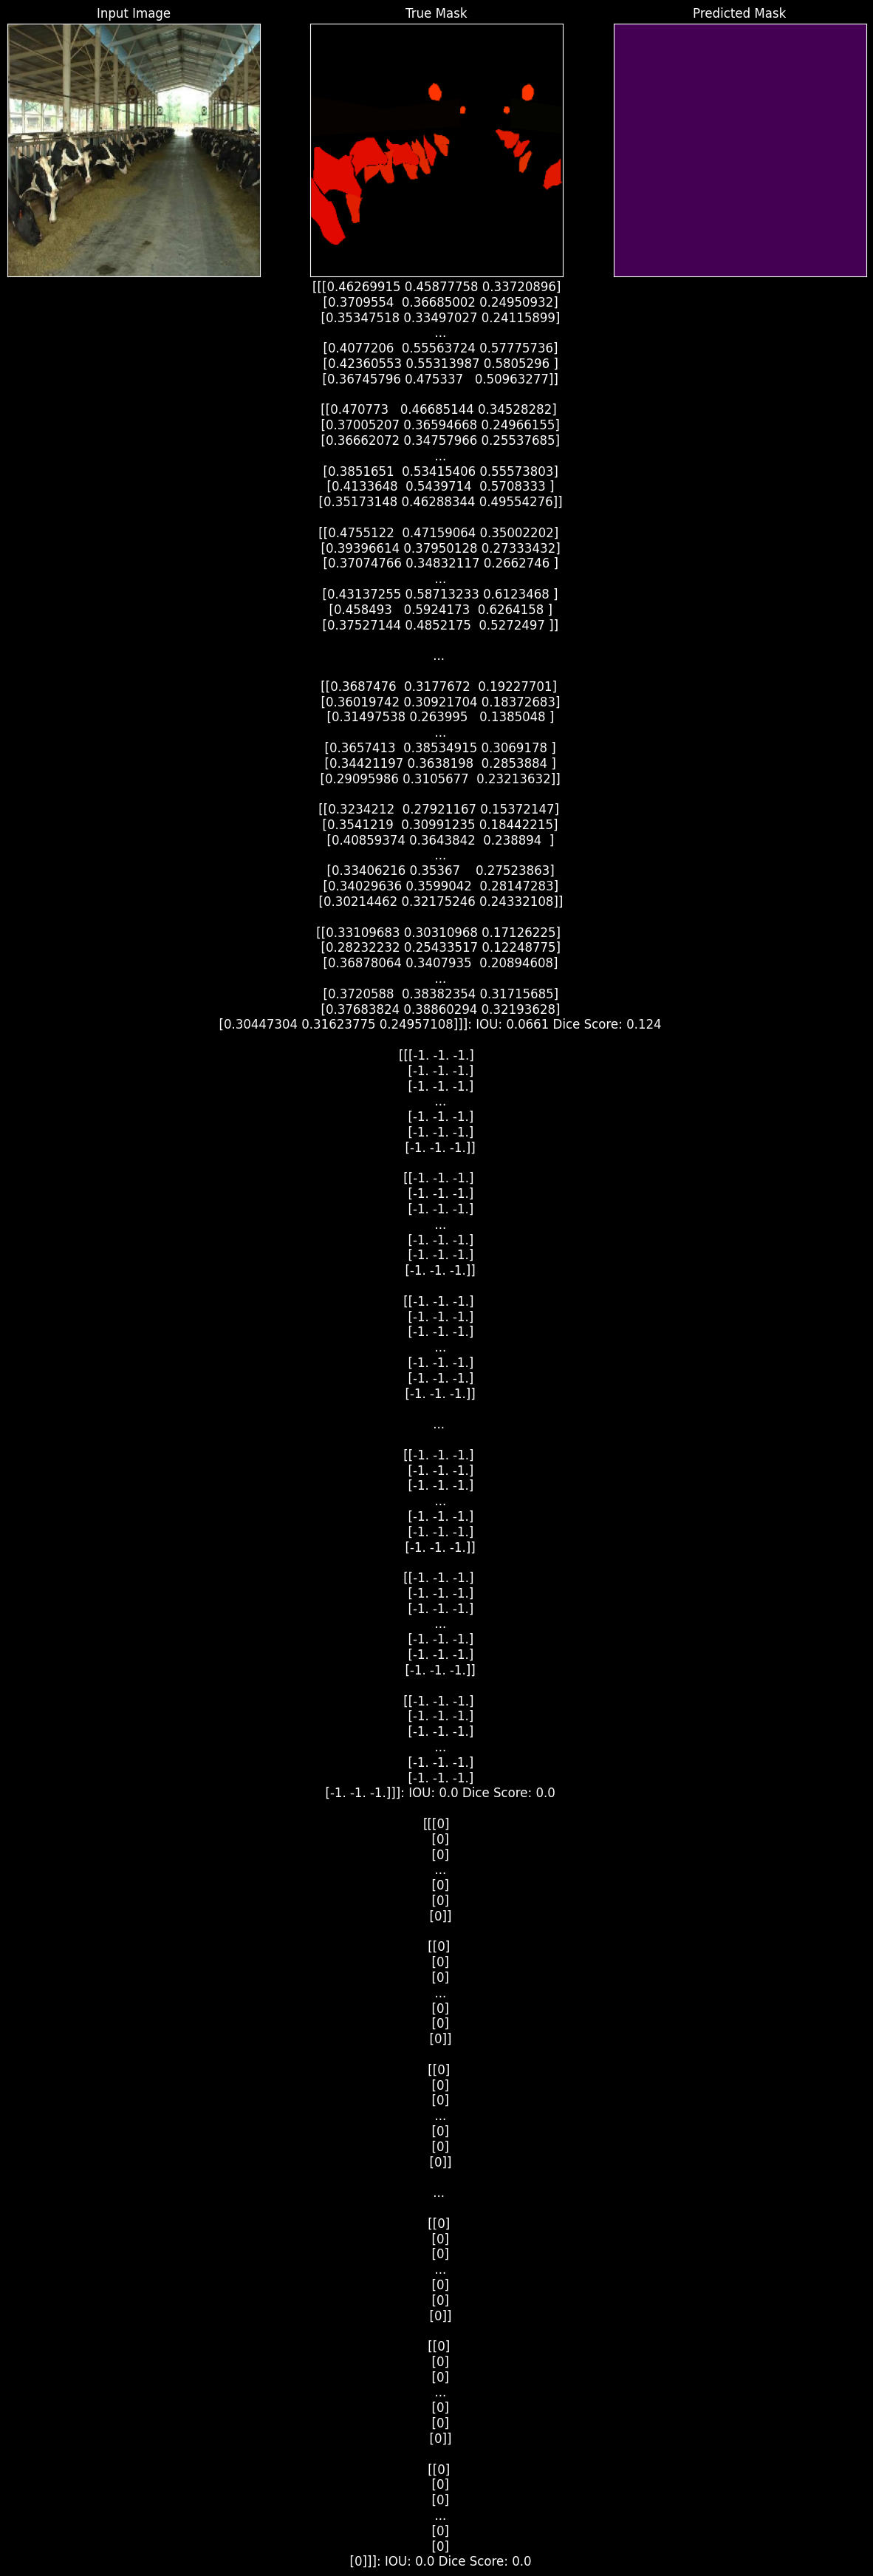

In [ ]:
def get_test_image_and_annotation_arrays():

	ds = test_ds.unbatch()
	ds = ds.batch(info.splits['test'].num_examples)

	images = []
	y_true_segments = []

	for image, annotation in ds.take(1):
		y_true_segments = annotation.numpy()
		images = image.numpy()

	y_true_segments = y_true_segments[:(
		info.splits['test'].num_examples - (info.splits['test']
											.num_examples % BATCH_SIZE))]
	images = images[:(info.splits['test'].num_examples -
					(info.splits['test'].num_examples % BATCH_SIZE))]

	return images, y_true_segments


y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

integer_slider = 1983
img = np.reshape(y_true_images[integer_slider], (1, width, height, 3))
y_pred_mask = model.predict(img)
y_pred_mask = create_mask(y_pred_mask)
y_pred_mask.shape


def display_prediction(display_list, display_string):
	plt.figure(figsize=(15, 15))
	title = ['Input Image', 'True Mask', 'Predicted Mask']

	for i in range(len(display_list)):
		plt.subplot(1, len(display_list), i+1)
		plt.title(title[i])
		plt.xticks([])
		plt.yticks([])
		if i == 1:
			plt.xlabel(display_string, fontsize=12)
		plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
	plt.show()


iou, dice_score = compute_metrics(
	y_true_segments[integer_slider], y_pred_mask.numpy())
display_list = [y_true_images[integer_slider],
				y_true_segments[integer_slider], y_pred_mask]

display_string_list = ["{}: IOU: {} Dice Score: {}".format(display_list[idx],
														i, dc) for idx, (i, dc) in
					enumerate(zip(np.round(iou, 4), np.round(dice_score, 4)))]
display_string = "\n\n".join(display_string_list)


# showing predictions with metrics
display_prediction(display_list, display_string)
